# 05a2 – Enhanced 3-Step Floating Catchment Area (E3SFCA) Scenario Modelling

## Overview

This notebook implements the **Enhanced 3-Step Floating Catchment Area (E3SFCA)** model to estimate spatial accessibility to CT scanner services across LSOAs in England. The E3SFCA method builds on the traditional 2SFCA by incorporating:

- Decay functions based on **realistic travel time bands** (car mode),
- **Weighted supply-to-demand ratios** per CT site (Rⱼ),
- **Aggregated accessibility scores (Fᵢ)** for each LSOA, reflecting cumulative opportunity adjusted for catchment overlap and travel friction.

This model serves as the **baseline scenario** for accessibility modelling prior to adding new sites or testing alternative service distributions.

---

## Key Objectives

- Apply a **stepwise decay function** to account for declining willingness to travel with increasing time.
- Compute supply-to-demand ratios (**Rⱼ**) at each CT facility using weighted demand from surrounding LSOAs.
- Generate accessibility scores (**Fᵢ**) per LSOA as the sum of all weighted contributions from accessible facilities.
- Export all outputs for downstream comparison and mapping (e.g., accessibility delta plots, prioritisation maps).

---

## Input Datasets

- LSOA-level demand estimates and geometry (`gdf_lsoa`)
- CT scanner site locations and capacity (`df_sites_ct`)
- Travel time matrix between all LSOAs and CT sites by car (`df_travel_car`)

---

## Outputs

The following datasets are exported to `/data/processed/E3SFCA/`:

- LSOA accessibility scores (GeoPackage + CSV)
- Travel matrix with decay weights
- CT site supply-to-demand ratio table (Rⱼ values)
- CT site capability table with scanner counts

---

## Planning Utility

The E3SFCA score (Fᵢ) can be used to:

- Identify LSOAs with **low spatial access** to CT scanning services,
- Support **site placement strategies** by revealing coverage deserts,
- Quantify the impact of **proposed infrastructure** on accessibility equity.

This model underpins scenario testing in subsequent notebooks (`05a3`, `06a`, etc.).


In [1]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import os

# Optional
import warnings
warnings.filterwarnings("ignore")


In [21]:
# ----------------------------------------------------------
# Step 1 – Load Baseline E3SFCA Files (Car Mode + Site Types)
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# E3SFCA input files
lsoa_access_path = os.path.join(processed_dir, "E3SFCA", "lsoa_e3sfca_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(processed_dir, "E3SFCA", "lsoa_to_ct_travel_matrix_car.csv")
ct_sites_path = os.path.join(processed_dir, "E3SFCA", "ct_sites_capability.csv")
rj_path = os.path.join(processed_dir, "E3SFCA", "ct_site_rj_scores_car.csv")

# Load baseline outputs
gdf_lsoa = gpd.read_file(lsoa_access_path)
df_travel_car = pd.read_csv(travel_matrix_path)
df_sites_ct = pd.read_csv(ct_sites_path)
df_rj_car = pd.read_csv(rj_path)

# Raw site capability input (for acute and CDC identification)
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")

df_sites_acute = pd.read_csv(acute_path)
df_sites_cdc = pd.read_csv(cdc_path)

travel_matrix_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw/LSOA_to_LSOA_complete.csv"

gpkg_path_master = os.path.join(raw_dir, "LSOA_5-year_segment_master.gpkg")

# Confirm shapes
print(f"LSOA GeoDataFrame: {gdf_lsoa.shape}")
print(f"Travel Matrix (car ≤60 min): {df_travel_car.shape}")
print(f"CT Sites: {df_sites_ct.shape}")
print(f"Acute Sites: {df_sites_acute.shape}")
print(f"CDC Sites: {df_sites_cdc.shape}")


LSOA GeoDataFrame: (3451, 8)
Travel Matrix (car ≤60 min): (20008, 10)
CT Sites: (36, 23)
Acute Sites: (18, 23)
CDC Sites: (24, 22)


In [22]:
# ----------------------------------------------------------
# Step 1a – Filter Acute and CDC Sites with >0 CT Scanners
# ----------------------------------------------------------

# Clean CT scanner columns (ensure numeric and fill NaNs as 0)
df_sites_acute["CT Scanners"] = pd.to_numeric(df_sites_acute["CT Scanners"], errors="coerce").fillna(0)
df_sites_cdc["CT Scanners"] = pd.to_numeric(df_sites_cdc["CT Scanners"], errors="coerce").fillna(0)

# Filter for sites with 1 or more scanners
df_acute_ct = df_sites_acute[df_sites_acute["CT Scanners"] > 0].copy()
df_cdc_ct = df_sites_cdc[df_sites_cdc["CT Scanners"] > 0].copy()

# Summary counts
print(f"Acute sites with ≥1 CT scanner: {df_acute_ct.shape[0]}")
print(f"CDC sites with ≥1 CT scanner: {df_cdc_ct.shape[0]}")


Acute sites with ≥1 CT scanner: 18
CDC sites with ≥1 CT scanner: 18


In [4]:
# ----------------------------------------------------------
# Step 1a – Filter Acute and CDC Sites with >0 CT Scanners
# ----------------------------------------------------------

# Clean CT scanner columns (ensure numeric and fill NaNs as 0)
df_sites_acute["CT Scanners"] = (
    pd.to_numeric(df_sites_acute["CT Scanners"], errors="coerce")
      .fillna(0)
      .astype(int)
)
df_sites_cdc["CT Scanners"] = (
    pd.to_numeric(df_sites_cdc["CT Scanners"], errors="coerce")
      .fillna(0)
      .astype(int)
)

# Filter for sites with ≥1 scanner
df_acute_ct = df_sites_acute[df_sites_acute["CT Scanners"] > 0].copy()
df_cdc_ct   = df_sites_cdc[df_sites_cdc["CT Scanners"] > 0].copy()

# Add a site_type column
df_acute_ct["site_type"] = "Acute"
df_cdc_ct  ["site_type"] = "CDC"

# Convert to GeoDataFrames for spatial consistency
acute_gdf = gpd.GeoDataFrame(
    df_acute_ct,
    geometry=gpd.points_from_xy(df_acute_ct["latitude"], df_acute_ct["longitude"]),
    crs="EPSG:4326"
)
cdc_gdf = gpd.GeoDataFrame(
    df_cdc_ct,
    
    # Corrected Geometry Assignment
    geometry=gpd.points_from_xy(df_acute_ct["latitude"], df_acute_ct["longitude"]),

    crs="EPSG:4326"
)

# Summary counts
print(f"Acute sites with ≥1 CT scanner: {acute_gdf.shape[0]}")
print(f"CDC   sites with ≥1 CT scanner: {cdc_gdf.shape[0]}")

# Quick head check
print("\nAcute CT sites sample:")
print(acute_gdf[["site_type", "Code", "Name", "CT Scanners", "geometry"]].head())

print("\nCDC CT sites sample:")
print(cdc_gdf[["site_type", "Code", "Name", "CT Scanners", "geometry"]].head())


Acute sites with ≥1 CT scanner: 18
CDC   sites with ≥1 CT scanner: 18

Acute CT sites sample:
  site_type   Code                            Name  CT Scanners  \
0     Acute  RTE01     Cheltenham General Hospital            2   
1     Acute  RTE03  Gloucestershire Royal Hospital            4   
2     Acute  RH5A8          Musgrove Park Hospital            3   
3     Acute  RH5O4        Yeovil District Hospital            2   
4     Acute  RA701         Bristol Royal Infirmary            5   

                    geometry  
0  POINT (-2.07188 51.89212)  
1  POINT (-2.23207 51.86638)  
2  POINT (-3.12169 51.01157)  
3  POINT (-2.63471 50.94484)  
4  POINT (-2.59614 51.45918)  

CDC CT sites sample:
  site_type   Code                    Name  CT Scanners  \
0       CDC  B4B4S  Bsw Banes Locality CDC            1   
1       CDC  K1W4U           Salisbury CDC            1   
2       CDC  O0D8X        West Swindon CDC            1   
3       CDC  O1F4J              Weston CDC            1   


In [5]:
# ----------------------------------------------------------
# Step 1b – Build the Baseline Supply GeoDataFrame
# ----------------------------------------------------------

# 1. Concatenate Acute and CDC GeoDataFrames
baseline_gdf = pd.concat([acute_gdf, cdc_gdf], ignore_index=True)

# 2. Standardise column names
baseline_gdf = baseline_gdf.rename(columns={
    "Name": "site_name",
    "CT Scanners": "scanner_count",
    "lsoa21cd": "destination_name"
})

# 3. Add site_type if missing (should already be set)
baseline_gdf["site_type"] = baseline_gdf["site_type"].fillna("Baseline")

# 4. Ensure CRS is WGS84
baseline_gdf = gpd.GeoDataFrame(baseline_gdf, geometry="geometry", crs="EPSG:4326")

# 5. Extract correct latitude and longitude from geometry (order: y = lat, x = lon)
baseline_gdf["latitude"] = baseline_gdf.geometry.y
baseline_gdf["longitude"] = baseline_gdf.geometry.x

# 6. Select & reorder columns to match scenario structure
baseline_gdf = baseline_gdf[
    ["site_name", "scanner_count", "site_type", 
     "latitude", "longitude", "geometry", "destination_name"]
].copy()

# 7. Quick head check
print("── Baseline Supply GeoDataFrame ──")
print(baseline_gdf.columns.tolist())
print(baseline_gdf.head())


── Baseline Supply GeoDataFrame ──
['site_name', 'scanner_count', 'site_type', 'latitude', 'longitude', 'geometry', 'destination_name']
                        site_name  scanner_count site_type   latitude  \
0     Cheltenham General Hospital              2     Acute  51.892120   
1  Gloucestershire Royal Hospital              4     Acute  51.866379   
2          Musgrove Park Hospital              3     Acute  51.011574   
3        Yeovil District Hospital              2     Acute  50.944843   
4         Bristol Royal Infirmary              5     Acute  51.459183   

   longitude                   geometry destination_name  
0  -2.071883  POINT (-2.07188 51.89212)        E01022116  
1  -2.232073  POINT (-2.23207 51.86638)        E01022312  
2  -3.121693  POINT (-3.12169 51.01157)        E01029302  
3  -2.634712  POINT (-2.63471 50.94484)        E01029231  
4  -2.596139  POINT (-2.59614 51.45918)        E01033904  


In [6]:
# ----------------------------------------------------------
# Step 2 – Identify Priority Underserved LSOAs (High Demand + Low Access)
# ----------------------------------------------------------

# 1. Define thresholds for "low access" (bottom 33%) and "high demand" (above median)
score_threshold = gdf_lsoa["enhanced_3sfca_score"].quantile(0.33)   # bottom 33%
demand_threshold = gdf_lsoa["ct_total_demand"].median()             # above-median demand

# 2. Apply filters
gdf_lsoa["low_access"] = gdf_lsoa["enhanced_3sfca_score"] <= score_threshold
gdf_lsoa["high_demand"] = gdf_lsoa["ct_total_demand"] >= demand_threshold

# 3. Tag LSOAs that meet both criteria
gdf_lsoa["priority_underserved"] = gdf_lsoa["low_access"] & gdf_lsoa["high_demand"]

# 4. Create filtered GeoDataFrame
gdf_priority = gdf_lsoa[gdf_lsoa["priority_underserved"]].copy()

# 5. Output check
print(f"Priority underserved LSOAs identified: {gdf_priority.shape[0]} of {gdf_lsoa.shape[0]}")


Priority underserved LSOAs identified: 709 of 3451


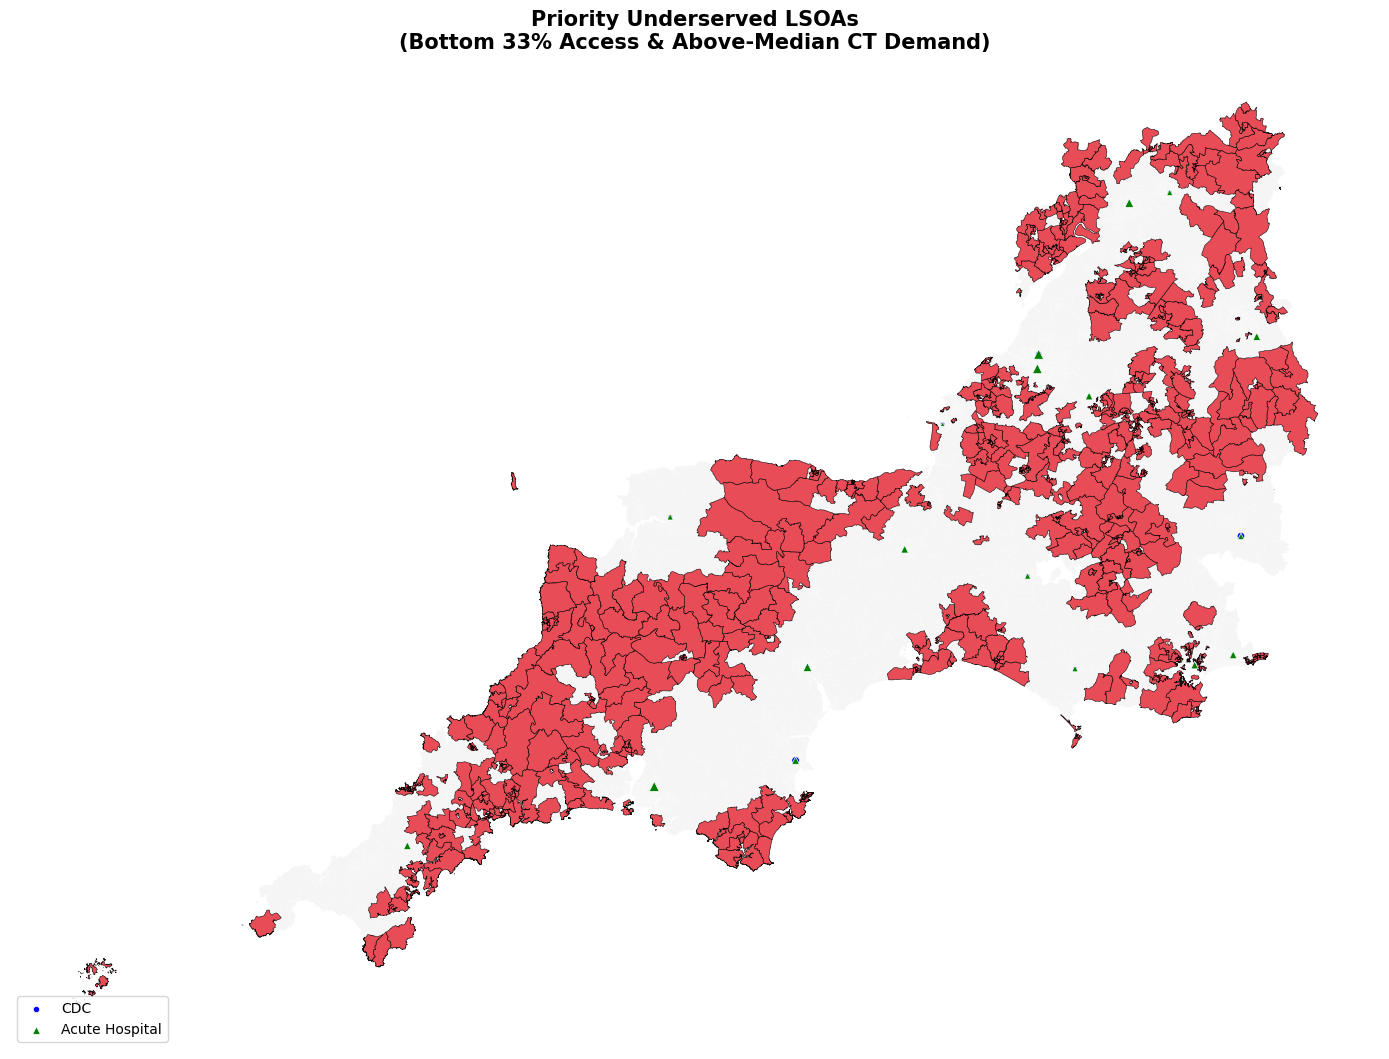

In [7]:
# ----------------------------------------------------------
# Step 2a – Visualise Priority Underserved LSOAs (Preferred Style)
# ----------------------------------------------------------

import matplotlib.pyplot as plt

# Reproject for alignment
gdf_lsoa_plot = gdf_lsoa.to_crs(epsg=3857)
gdf_priority = gdf_lsoa_plot[gdf_lsoa_plot["priority_underserved"] == True]
cdc_gdf_3857 = cdc_gdf.to_crs(epsg=3857)
acute_gdf_3857 = acute_gdf.to_crs(epsg=3857)

# Set up plot
fig, ax = plt.subplots(figsize=(14, 11))

# Base layer – all LSOAs
gdf_lsoa_plot.plot(
    ax=ax,
    color="#f5f5f5",
    edgecolor="white",
    linewidth=0.1
)

# Highlight priority underserved LSOAs
gdf_priority.plot(
    ax=ax,
    color="#e63946",
    edgecolor="black",
    linewidth=0.4,
    alpha=0.9
)

# Scale marker size by CT scanner count
size_scale = 10

# Plot CDCs – blue circles
cdc_gdf_3857.plot(
    ax=ax,
    color="blue",
    markersize=cdc_gdf_3857["CT Scanners"] * size_scale,
    label="CDC",
    marker="o",
    edgecolor="white",
    linewidth=0.5
)

# Plot Acute Hospitals – green triangles
acute_gdf_3857.plot(
    ax=ax,
    color="green",
    markersize=acute_gdf_3857["CT Scanners"] * size_scale,
    label="Acute Hospital",
    marker="^",
    edgecolor="white",
    linewidth=0.5
)

# Final formatting
ax.set_title(
    "Priority Underserved LSOAs\n(Bottom 33% Access & Above-Median CT Demand)",
    fontsize=15,
    weight="bold"
)

ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("priority_lsoas_facilities_corrected.png", dpi=300, bbox_inches="tight")
plt.show()



In [8]:
# ----------------------------------------------------------
# Step 2b – Propose Total CT Scanner Uplift Scenarios (5%, 10%, 20%)
# ----------------------------------------------------------

# Calculate current total scanners
current_total_scanners = df_sites_ct["CT Scanners"].sum()
print(f"Current total CT scanners: {current_total_scanners}")

# Define percentage increases
uplift_factors = [0.05, 0.10, 0.20]

# Create scenario summary table
uplift_summary = []

for factor in uplift_factors:
    new_total = round(current_total_scanners * (1 + factor))
    uplift = new_total - current_total_scanners
    uplift_summary.append({
        "Scenario": f"+{int(factor * 100)}%",
        "New Total CT Scanners": new_total,
        "Uplift": uplift
    })

# Convert to DataFrame for display
df_uplift = pd.DataFrame(uplift_summary)
print(df_uplift)


Current total CT scanners: 78
  Scenario  New Total CT Scanners  Uplift
0      +5%                     82       4
1     +10%                     86       8
2     +20%                     94      16


In [35]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans

ISLES_OF_SCILLY_CODE = "E01019077"  # Optional: guard against remote outlier site

def generate_clustered_scenario_sites_v3(
    gdf_priority,
    gpkg_path_master,
    travel_matrix_path,
    scenario_configs,
    score_col="enhanced_3sfca_score",
    demand_col="ct_total_demand"
):
    """
    Creates travel-time optimal CT site locations from underserved LSOAs using KMeans clustering.
    Uses total intra-cluster travel time to select the most central LSOA per cluster.
    Falls back if travel data is sparse. Outputs GeoDataFrames per scenario.
    """
    gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]
    gdf_priority = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")

    df_tt = pd.read_csv(travel_matrix_path)
    df_tt[["origin_name", "destination_name"]] = df_tt[["origin_name", "destination_name"]].astype(str)

    scenario_outputs = {}

    for scenario, config in scenario_configs.items():
        print(f"\n📦 Scenario: {scenario}")
        n_clusters = config["n_clusters"]
        scanner_allocation = config["scanner_allocation"]

        if len(scanner_allocation) != n_clusters:
            raise ValueError(f"{scenario} mismatch between n_clusters and scanner_allocation")

        gdf_scenario = gdf_priority.copy()
        coords = gdf_scenario[["bng_e", "bng_n"]].values
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        gdf_scenario["cluster"] = kmeans.fit_predict(coords)

        cluster_sites = []
        skipped_clusters = []

        for cluster_id in range(n_clusters):
            cluster_lsoas = gdf_scenario[gdf_scenario["cluster"] == cluster_id].copy()
            lsoa_ids = [lsoa for lsoa in cluster_lsoas["lsoa21cd"] if lsoa != ISLES_OF_SCILLY_CODE]

            df_sub = df_tt[
                df_tt["origin_name"].isin(lsoa_ids) &
                df_tt["destination_name"].isin(lsoa_ids) &
                (df_tt["origin_name"] != df_tt["destination_name"])
            ]

            if df_sub.empty:
                print(f"Cluster {cluster_id}: no travel pairs. Fallback used.")
                fallback = cluster_lsoas[cluster_lsoas["lsoa21cd"] != ISLES_OF_SCILLY_CODE].iloc[0]
                site_row = gdf_centroids[gdf_centroids["lsoa21cd"] == fallback["lsoa21cd"]].copy()
                site_row["travel_time_sum"] = None
                skipped_clusters.append(cluster_id)
            else:
                total_tt = (
                    df_sub.groupby("origin_name")["travel_time_car"]
                    .sum().reset_index()
                    .rename(columns={"origin_name": "lsoa21cd", "travel_time_car": "travel_time_sum"})
                )
                best_lsoa = (
                    total_tt.merge(cluster_lsoas, on="lsoa21cd", how="left")
                    .sort_values("travel_time_sum")
                    .iloc[0]
                )
                site_row = gdf_centroids[gdf_centroids["lsoa21cd"] == best_lsoa["lsoa21cd"]].copy()
                site_row["travel_time_sum"] = best_lsoa["travel_time_sum"]

            # Metadata
            site_row["centroid_point"] = site_row.geometry.centroid
            site_row["total_demand"] = cluster_lsoas[demand_col].sum()
            site_row["avg_access_score"] = cluster_lsoas[score_col].mean()
            site_row["lsoa_count"] = len(cluster_lsoas)
            site_row["cluster"] = cluster_id
            site_row["CT Scanners"] = scanner_allocation[cluster_id]
            site_row["Site Name"] = f"Scenario Site {cluster_id + 1}"
            site_row["Type"] = f"Scenario {scenario}"

            cluster_sites.append(site_row)

        gdf_sites = pd.concat(cluster_sites).reset_index(drop=True)
        gdf_sites = gpd.GeoDataFrame(gdf_sites, geometry="geometry", crs="EPSG:27700")

        print(f"Clusters processed: {n_clusters} | Skipped: {len(skipped_clusters)}")
        print(f"Travel Time Summary:\n{gdf_sites['travel_time_sum'].describe().round(3)}")

        scenario_outputs[scenario] = gdf_sites

    return scenario_outputs



📦 Scenario: +5%
Clusters processed: 4 | Skipped: 0
Travel Time Summary:
count       4.000
mean     2689.821
std      3109.614
min         0.000
25%         0.000
50%      2597.257
75%      5287.077
max      5564.771
Name: travel_time_sum, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


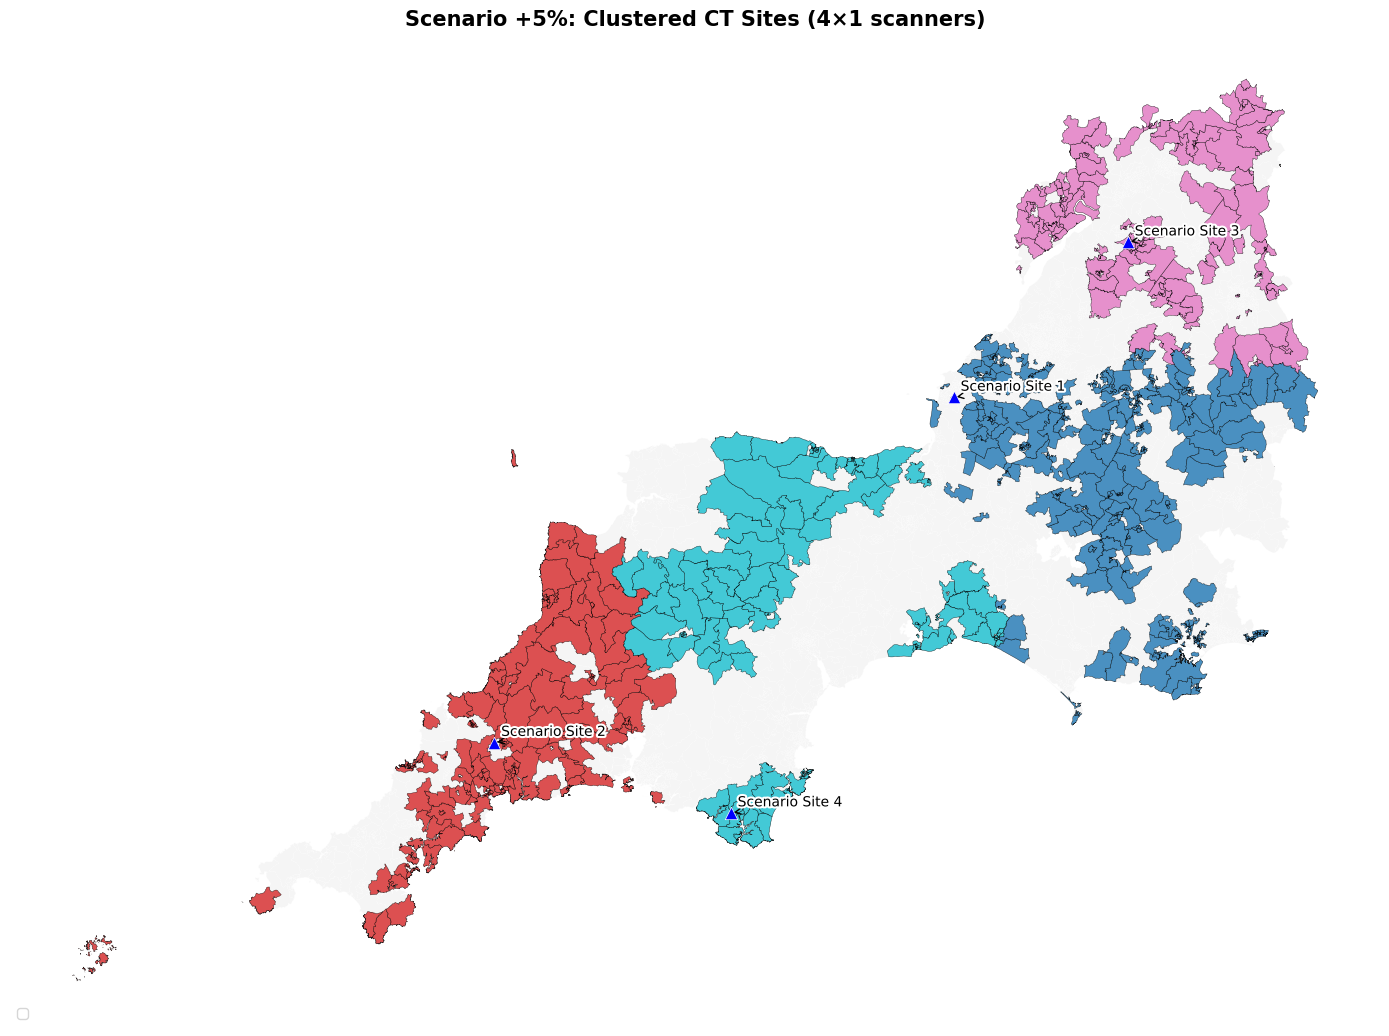

In [36]:
# ----------------------------------------------------------
# Step 3a – Visualise Scenario +5% with Clusters (Preferred UK Style)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Config
config_5 = {"+5%": {"n_clusters": 4, "scanner_allocation": [1, 1, 1, 1]}}
n_clusters = config_5["+5%"]["n_clusters"]

# Generate site outputs
sites_5pct = generate_clustered_scenario_sites_v3(
    gdf_priority=gdf_priority,
    gpkg_path_master=gpkg_path_master,
    travel_matrix_path=travel_matrix_path,
    scenario_configs=config_5
)["+5%"]

# Recluster for visual clusters
gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]
gdf_priority_joined = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")
gdf_priority_joined.set_geometry("geometry_y", inplace=True)

coords = gdf_priority_joined[["bng_e", "bng_n"]].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
gdf_priority_joined["cluster"] = kmeans.fit_predict(coords)

# Reproject
gdf_lsoa_proj = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_proj = gdf_priority_joined.to_crs(epsg=3857)
sites_5pct_proj = sites_5pct.to_crs(epsg=3857)
sites_5pct_proj["centroid_point"] = sites_5pct["centroid_point"].to_crs(epsg=3857)

# Colour map
cmap = cm.get_cmap("tab10", n_clusters)

# Plot
fig, ax = plt.subplots(figsize=(14, 11))
gdf_lsoa_proj.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.1)

# Plot clusters
for cluster_id in range(n_clusters):
    gdf_cluster = gdf_priority_proj[gdf_priority_proj["cluster"] == cluster_id]
    gdf_cluster.plot(
        ax=ax,
        color=mcolors.to_hex(cmap(cluster_id)),
        edgecolor="black",
        linewidth=0.3,
        alpha=0.8,
        label=f"Cluster {cluster_id + 1}"
    )

# Plot site markers
for _, row in sites_5pct_proj.iterrows():
    pt = row["centroid_point"]
    ax.scatter(pt.x, pt.y, marker="^", s=80, color="blue", edgecolor="white", linewidth=0.5, zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(pt.x, pt.y),
        xytext=(pt.x + 3000, pt.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Final styling
ax.set_title("Scenario +5%: Clustered CT Sites (4×1 scanners)", fontsize=15, weight="bold")
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("scenario_5pct_cluster_colours.png", dpi=300, bbox_inches="tight")
plt.show()



📦 Scenario: +10%
Clusters processed: 6 | Skipped: 0
Travel Time Summary:
count       6.000
mean     1268.721
std      2042.807
min         0.000
25%         0.000
50%         0.000
75%      2194.481
max      4686.352
Name: travel_time_sum, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


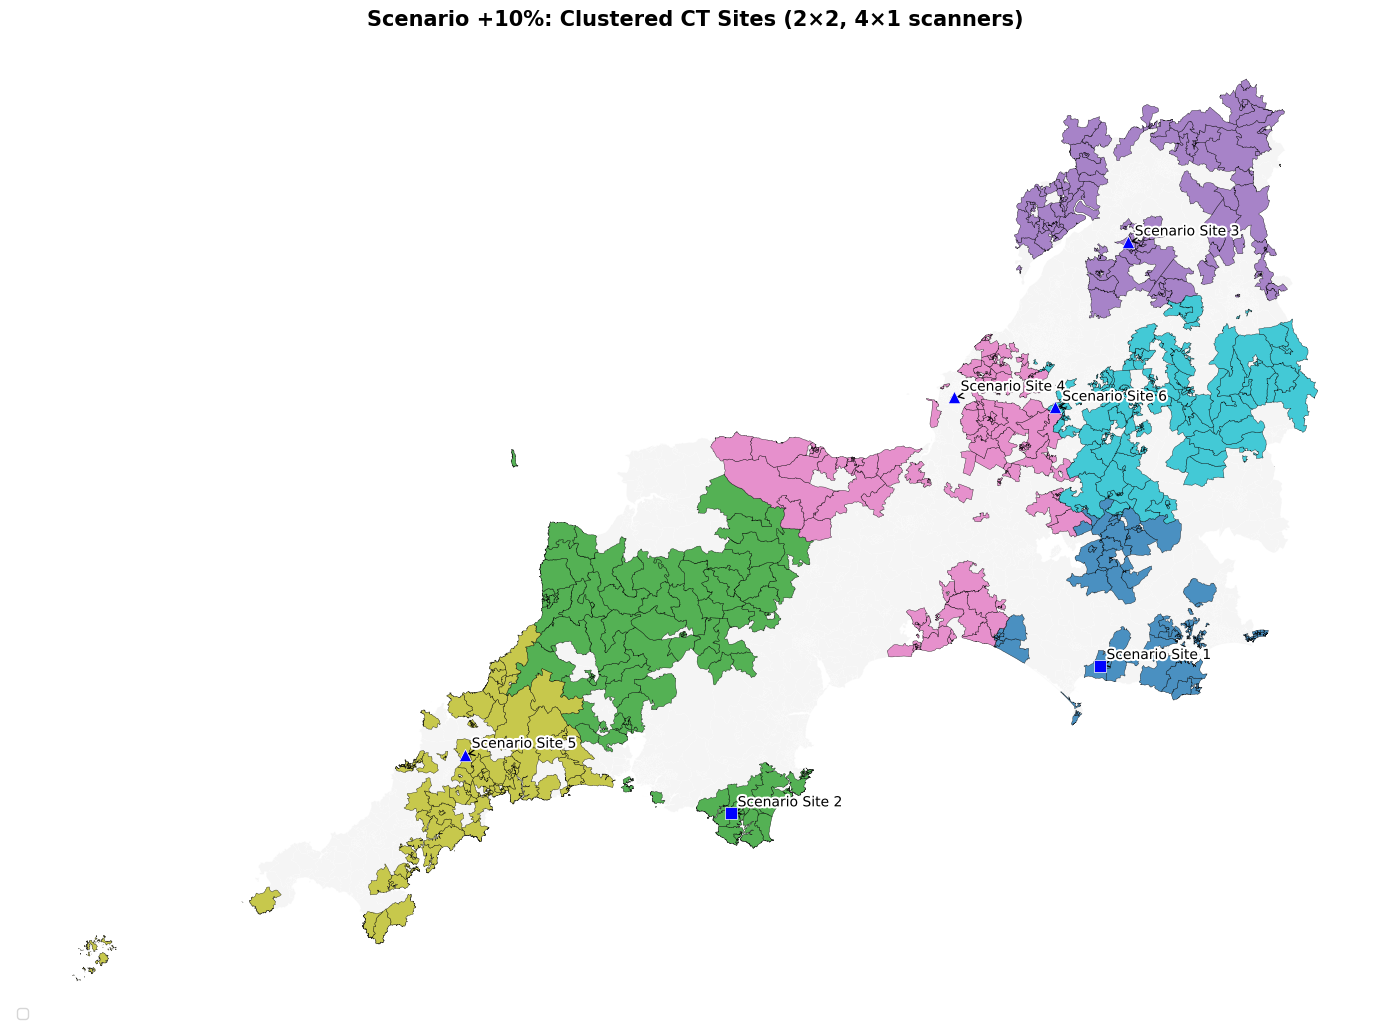

In [37]:
# ----------------------------------------------------------
# Step 3b – Visualise Scenario +10% with Clusters (Preferred UK Style)
# ----------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define +10% scenario config
config_10 = {"+10%": {"n_clusters": 6, "scanner_allocation": [2, 2, 1, 1, 1, 1]}}
n_clusters = config_10["+10%"]["n_clusters"]

# Generate scenario site locations (travel-time-based V3)
sites_10pct = generate_clustered_scenario_sites_v3(
    gdf_priority=gdf_priority,
    gpkg_path_master=gpkg_path_master,
    travel_matrix_path=travel_matrix_path,
    scenario_configs=config_10
)["+10%"]

# Recluster LSOAs to show colour-coded clusters
gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]
gdf_priority_joined = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")
gdf_priority_joined.set_geometry("geometry_y", inplace=True)  # Fix geometry handling

# Run KMeans on BNG coords
coords = gdf_priority_joined[["bng_e", "bng_n"]].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
gdf_priority_joined["cluster"] = kmeans.fit_predict(coords)

# Reproject all layers
gdf_lsoa_proj = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_proj = gdf_priority_joined.to_crs(epsg=3857)
sites_10pct_proj = sites_10pct.to_crs(epsg=3857)
sites_10pct_proj["centroid_point"] = sites_10pct["centroid_point"].to_crs(epsg=3857)

# Colour palette for clusters
cmap = cm.get_cmap("tab10", n_clusters)

# Plot setup
fig, ax = plt.subplots(figsize=(14, 11))

# Base LSOAs
gdf_lsoa_proj.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.1)

# Plot LSOAs by cluster
for cluster_id in range(n_clusters):
    gdf_cluster = gdf_priority_proj[gdf_priority_proj["cluster"] == cluster_id]
    gdf_cluster.plot(
        ax=ax,
        color=mcolors.to_hex(cmap(cluster_id)),
        edgecolor="black",
        linewidth=0.3,
        alpha=0.8,
        label=f"Cluster {cluster_id + 1}"
    )

# Plot site markers
for _, row in sites_10pct_proj.iterrows():
    pt = row["centroid_point"]
    marker = "^" if row["CT Scanners"] == 1 else "s"
    ax.scatter(pt.x, pt.y, marker=marker, s=80, color="blue", edgecolor="white", linewidth=0.5, zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(pt.x, pt.y),
        xytext=(pt.x + 3000, pt.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Final formatting
ax.set_title("Scenario +10%: Clustered CT Sites (2×2, 4×1 scanners)", fontsize=15, weight="bold")
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("scenario_10pct_cluster_colours.png", dpi=300, bbox_inches="tight")
plt.show()



📦 Scenario: +20%
Clusters processed: 8 | Skipped: 0
Travel Time Summary:
count       8.000
mean     1956.248
std      1703.220
min         0.000
25%         0.000
50%      2429.585
75%      3321.370
max      4016.173
Name: travel_time_sum, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


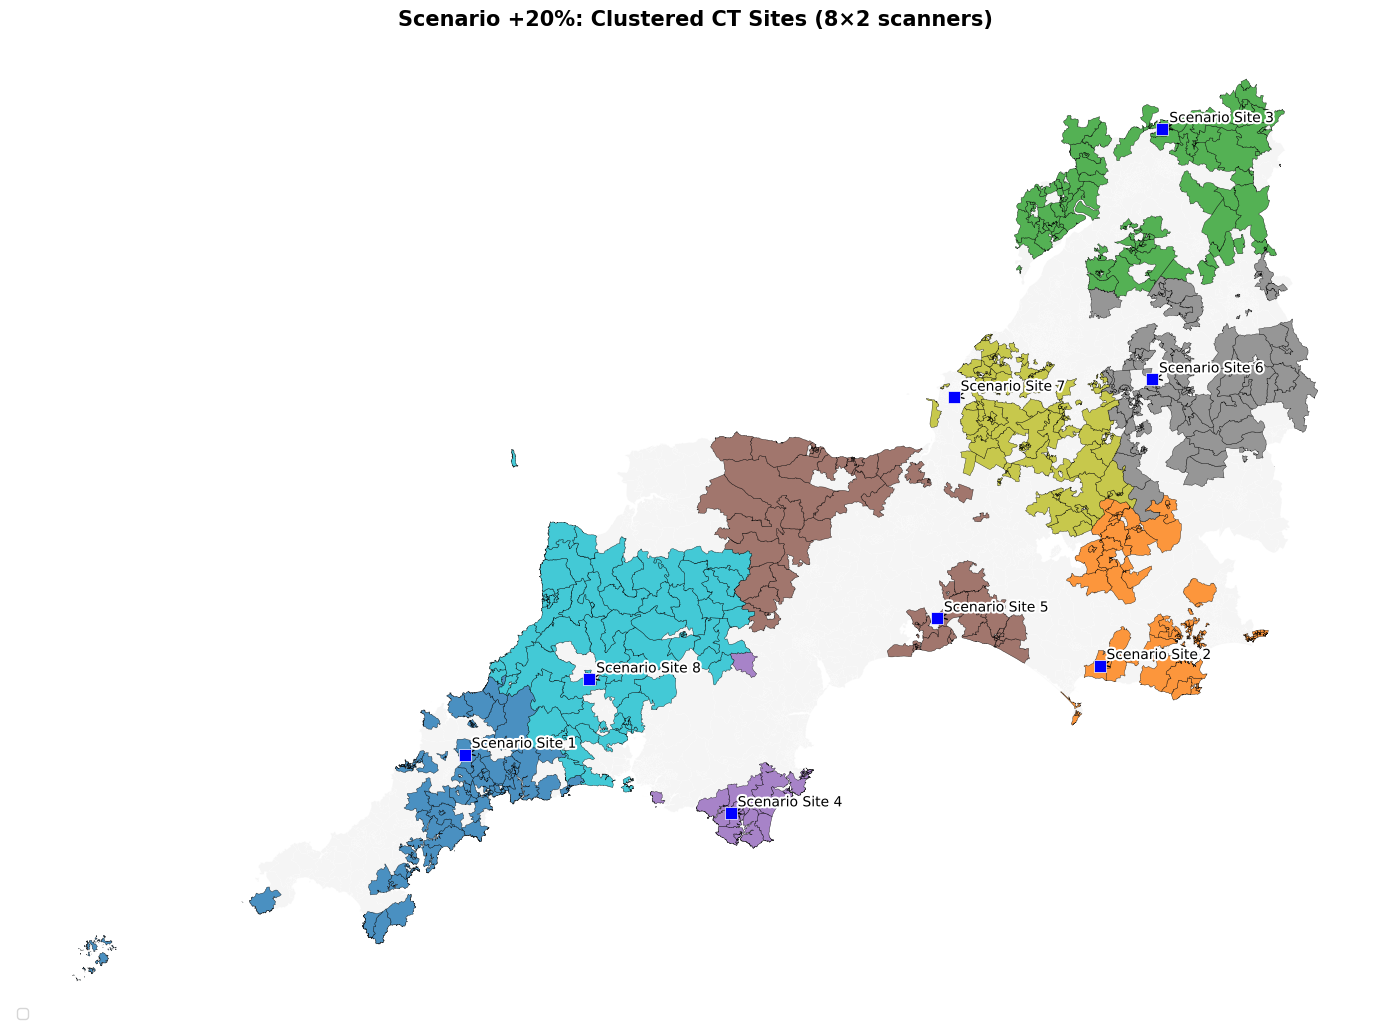

In [38]:
# ----------------------------------------------------------
# Step 3c – Visualise Scenario +20% with Clusters (Preferred UK Style)
# ----------------------------------------------------------

# Config
config_20 = {"+20%": {"n_clusters": 8, "scanner_allocation": [2] * 8}}
n_clusters = config_20["+20%"]["n_clusters"]

# Generate sites
sites_20pct = generate_clustered_scenario_sites_v3(
    gdf_priority=gdf_priority,
    gpkg_path_master=gpkg_path_master,
    travel_matrix_path=travel_matrix_path,
    scenario_configs=config_20
)["+20%"]

# Recluster
gdf_centroids = gpd.read_file(gpkg_path_master)[["lsoa21cd", "bng_e", "bng_n", "geometry"]]
gdf_priority_joined = gdf_priority.merge(gdf_centroids, on="lsoa21cd", how="left")
gdf_priority_joined.set_geometry("geometry_y", inplace=True)

coords = gdf_priority_joined[["bng_e", "bng_n"]].values
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
gdf_priority_joined["cluster"] = kmeans.fit_predict(coords)

# Reproject
gdf_lsoa_proj = gdf_lsoa.to_crs(epsg=3857)
gdf_priority_proj = gdf_priority_joined.to_crs(epsg=3857)
sites_20pct_proj = sites_20pct.to_crs(epsg=3857)
sites_20pct_proj["centroid_point"] = sites_20pct["centroid_point"].to_crs(epsg=3857)

# Colour map
cmap = cm.get_cmap("tab10", n_clusters)

# Plot
fig, ax = plt.subplots(figsize=(14, 11))
gdf_lsoa_proj.plot(ax=ax, color="#f5f5f5", edgecolor="white", linewidth=0.1)

# Plot clusters
for cluster_id in range(n_clusters):
    gdf_cluster = gdf_priority_proj[gdf_priority_proj["cluster"] == cluster_id]
    gdf_cluster.plot(
        ax=ax,
        color=mcolors.to_hex(cmap(cluster_id)),
        edgecolor="black",
        linewidth=0.3,
        alpha=0.8,
        label=f"Cluster {cluster_id + 1}"
    )

# Plot site markers (squares for 2 scanners)
for _, row in sites_20pct_proj.iterrows():
    pt = row["centroid_point"]
    ax.scatter(pt.x, pt.y, marker="s", s=80, color="blue", edgecolor="white", linewidth=0.5, zorder=5)
    ax.annotate(
        row["Site Name"],
        xy=(pt.x, pt.y),
        xytext=(pt.x + 3000, pt.y + 3000),
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        fontsize=10,
        path_effects=[path_effects.withStroke(linewidth=3, foreground="white")]
    )

# Final styling
ax.set_title("Scenario +20%: Clustered CT Sites (8×2 scanners)", fontsize=15, weight="bold")
ax.axis("off")
ax.legend(loc="lower left", frameon=True)
plt.tight_layout()
plt.savefig("scenario_20pct_cluster_colours.png", dpi=300, bbox_inches="tight")
plt.show()


In [39]:
# ----------------------------------------------------------
# Step 4 – Ranked Summary of Proposed Sites per Scenario
# ----------------------------------------------------------

for df in [sites_5pct, sites_10pct, sites_20pct]:
    if "rank" not in df.columns:
        df["rank_score"] = (
            df["total_demand"].rank(ascending=False) +
            df["avg_access_score"].rank(ascending=True)
        )
        df["rank"] = df["rank_score"].rank(method="dense").astype(int)


columns_to_show = ["Site Name", "total_demand", "avg_access_score", "rank"]

def print_site_summary(scenario_title, df):
    print(f"\n{scenario_title}")
    missing = [col for col in columns_to_show if col not in df.columns]
    if missing:
        print(f"Missing columns: {missing}")
    else:
        print(df[columns_to_show].sort_values("rank").to_string(index=False))

# +5% Scenario
print_site_summary("+5% Scenario: 4x CT Sites (1 scanner each)", sites_5pct)

# +10% Scenario
print_site_summary("+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)", sites_10pct)

# +20% Scenario
print_site_summary("+20% Scenario: 8x CT Sites (2 scanners each)", sites_20pct)



+5% Scenario: 4x CT Sites (1 scanner each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 2  35504.140702          0.000040     1
Scenario Site 1  73411.160569          0.000053     2
Scenario Site 3  36248.401217          0.000053     2
Scenario Site 4  28208.848521          0.000045     3

+10% Scenario: 6x CT Sites (2×2, 4×1 scanners)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 6  36226.551164          0.000048     1
Scenario Site 2  25385.294799          0.000038     2
Scenario Site 3  31386.128354          0.000051     2
Scenario Site 4  30557.543418          0.000053     3
Scenario Site 5  24358.371016          0.000044     3
Scenario Site 1  25458.662258          0.000059     4

+20% Scenario: 8x CT Sites (2 scanners each)
      Site Name  total_demand  avg_access_score  rank
Scenario Site 6  28578.311664          0.000048     1
Scenario Site 8  18938.123232          0.000034     2
Scenario Site 1  21394.351842          0.000045     

### How Are New CT Scanner Sites Located?

This scenario modelling approach uses a **travel-time-optimised**, data-driven method to place new CT scanner sites based on population need and geographic accessibility. Here's how it works:

---

#### 1. Identify Underserved Areas

The model begins by identifying neighbourhoods (LSOAs) that:

* Have **high CT demand** (based on projected need), and  
* Have **low spatial access** to current CT facilities (using the Enhanced 3-Step Floating Catchment Area score – E3SFCA).

These LSOAs form the basis for clustering and site planning.

---

#### 2. Group LSOAs Into Travel-Based Clusters

The priority LSOAs are grouped using **K-Means clustering** on their actual coordinates (Eastings and Northings).  
Each cluster represents a distinct area where **unmet diagnostic need** is concentrated.

---

#### 3. Select Optimal Site Within Each Cluster

Rather than placing a site at the geometric centre of each cluster, the model:

* Calculates **total travel time** from each LSOA to all others within the cluster (using a full LSOA-to-LSOA matrix),  
* Selects the LSOA with the **lowest total travel time** as the **most central** and **accessible** location for a new CT scanner.

This ensures that new sites are optimally located for real-world access.

---

#### 4. Allocate Scanners Based on Demand and Equity

Scanners are distributed across the selected sites according to the chosen **uplift scenario**:

* For example, in a **+10% scenario** (6 new scanners), the model may assign:  
  * **2 scanners** to each of the highest-demand clusters, and  
  * **1 scanner** to clusters with moderate need and poorer access.

Allocation is based on a composite ranking of **total demand** and **average access score** for each cluster.

---

#### 5. Anchor Each Site to a Real LSOA

Each proposed site is directly linked to a **real-world LSOA boundary**. This enables:

* Integration with population, travel time, and IMD datasets,  
* Accurate **geospatial plotting**,  
* Use in reporting and system-level modelling.

---

#### Summary

> The model finds the most underserved neighbourhoods, clusters them geographically, and identifies the LSOA with the best real-world access profile within each group. New scanner sites are placed in these LSOAs, with scanners allocated proportionally based on local demand and access inequality. Each site is fully anchored to real boundaries, enabling analysis, mapping, and NHS planning.


In [40]:
# ----------------------------------------------------------
# Step 5 – Prepare Minimal Outputs for Scenario and Baseline Sites
# ----------------------------------------------------------

# Rename and select fields for +5% scenario
sites_5 = sites_5pct.rename(columns={
    "nearest_lsoa21cd": "lsoa21cd",
    "CT Scanners": "scanner_count"
})[["Site Name", "lsoa21cd", "bng_e", "bng_n", "scanner_count"]].copy()

# Rename and select fields for +10% scenario
sites_10 = sites_10pct.rename(columns={
    "nearest_lsoa21cd": "lsoa21cd",
    "CT Scanners": "scanner_count"
})[["Site Name", "lsoa21cd", "bng_e", "bng_n", "scanner_count"]].copy()

# Rename and select fields for +20% scenario
sites_20 = sites_20pct.rename(columns={
    "nearest_lsoa21cd": "lsoa21cd",
    "CT Scanners": "scanner_count"
})[["Site Name", "lsoa21cd", "bng_e", "bng_n", "scanner_count"]].copy()



In [46]:
print(sites_5[["Site Name", "scanner_count"]])
print(sites_10[["Site Name", "scanner_count"]])
print(sites_20[["Site Name", "scanner_count"]])


         Site Name  scanner_count
0  Scenario Site 1              1
1  Scenario Site 2              1
2  Scenario Site 3              1
3  Scenario Site 4              1
         Site Name  scanner_count
0  Scenario Site 1              2
1  Scenario Site 2              2
2  Scenario Site 3              1
3  Scenario Site 4              1
4  Scenario Site 5              1
5  Scenario Site 6              1
         Site Name  scanner_count
0  Scenario Site 1              2
1  Scenario Site 2              2
2  Scenario Site 3              2
3  Scenario Site 4              2
4  Scenario Site 5              2
5  Scenario Site 6              2
6  Scenario Site 7              2
7  Scenario Site 8              2


In [41]:
# ----------------------------------------------------------
# Step 6 – Prepare Minimal Baseline Sites (CDC + Acute)
# ----------------------------------------------------------

import geopandas as gpd
import pandas as pd

# Load and filter
df_acute = pd.read_csv(acute_path)
df_cdc = pd.read_csv(cdc_path)

df_acute = df_acute[(df_acute["CT Scanners"] > 0) & df_acute["latitude"].notna() & df_acute["longitude"].notna()]
df_cdc = df_cdc[(df_cdc["CT Scanners"] > 0) & df_cdc["latitude"].notna() & df_cdc["longitude"].notna()]

# Add site type
df_acute["site_type"] = "Acute"
df_cdc["site_type"] = "CDC"

# Standardise columns
columns_needed = ["Name", "CT Scanners", "site_type", "lsoa21cd", "latitude", "longitude"]
df_acute = df_acute[columns_needed].copy()
df_cdc = df_cdc[columns_needed].copy()

# Combine
df_all = pd.concat([df_acute, df_cdc], ignore_index=True)
df_all.rename(columns={"Name": "site_name", "CT Scanners": "scanner_count"}, inplace=True)

# Convert to GeoDataFrame
gdf_baseline = gpd.GeoDataFrame(
    df_all,
    geometry=gpd.points_from_xy(df_all["longitude"], df_all["latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=27700)

# Add British National Grid coordinates
gdf_baseline["bng_e"] = gdf_baseline.geometry.x
gdf_baseline["bng_n"] = gdf_baseline.geometry.y

# Final export columns
columns_export = [
    "site_name", "scanner_count", "site_type", "lsoa21cd", "bng_e", "bng_n", "geometry"
]
baseline_sites = gdf_baseline[columns_export].copy()

# Preview
print("Baseline sites shape:", baseline_sites.shape)
display(baseline_sites.head())


Baseline sites shape: (36, 7)


,site_name,scanner_count,site_type,lsoa21cd,bng_e,bng_n,geometry
0,Cheltenham General Hospital,2,Acute,E01022116,7.549455e+06,-5.917795e+06,POINT (7549454.977 -5917795.016)
1,Gloucestershire Royal Hospital,4,Acute,E01022312,7.543011e+06,-5.947684e+06,POINT (7543011.153 -5947684.423)
2,Musgrove Park Hospital,3,Acute,E01029302,7.372655e+06,-6.102918e+06,POINT (7372655.066 -6102918.233)
3,Yeovil District Hospital,2,Acute,E01029231,7.366354e+06,-6.012574e+06,POINT (7366354.119 -6012574.417)
4,Bristol Royal Infirmary,5,Acute,E01033904,7.462448e+06,-6.011347e+06,POINT (7462448.343 -6011347.323)


In [42]:
# ----------------------------------------------------------
# Step 7 – Prepare Minimal Output for Baseline Sites (CDC + Acute)
# ----------------------------------------------------------

# Ensure geometry is in correct CRS and extract centroids
baseline_proj = baseline_sites.to_crs(epsg=27700).copy()
baseline_proj["bng_e"] = baseline_proj.geometry.x
baseline_proj["bng_n"] = baseline_proj.geometry.y

# Assign consistent structure (LSOA optional, can add via spatial join if needed)
baseline_simple = baseline_proj.rename(columns={
    "site_name": "Site Name"
})[["Site Name", "scanner_count", "bng_e", "bng_n"]].copy()
baseline_simple["lsoa21cd"] = None  # Placeholder

# Reorder columns to match scenarios
baseline_simple = baseline_simple[["Site Name", "lsoa21cd", "bng_e", "bng_n", "scanner_count"]]



In [45]:
# ----------------------------------------------------------
# Step 8 – Export All Minimal Files to CSV
# ----------------------------------------------------------

# Ensure baseline_simple has the same structure
baseline_simple = baseline_sites.rename(columns={
    "site_name": "Site Name"
})[["Site Name", "lsoa21cd", "bng_e", "bng_n", "scanner_count"]].copy()

# Combine baseline with each scenario
sites_5_combined = pd.concat([sites_5, baseline_simple], ignore_index=True)
sites_10_combined = pd.concat([sites_10, baseline_simple], ignore_index=True)
sites_20_combined = pd.concat([sites_20, baseline_simple], ignore_index=True)

# ----------------------------------------------------------
# Step 9 – Export Combined CSVs to Scenario Folder
# ----------------------------------------------------------

# Define output directory
output_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/E3SFCA_Scenarios"

# Export each scenario with baseline sites included
sites_5_combined.to_csv(f"{output_dir}/scenario_5pct_plus_baseline.csv", index=False)
sites_10_combined.to_csv(f"{output_dir}/scenario_10pct_plus_baseline.csv", index=False)
sites_20_combined.to_csv(f"{output_dir}/scenario_20pct_plus_baseline.csv", index=False)

# Also export standalone baseline sites
baseline_simple.to_csv(f"{output_dir}/baseline_ct_sites.csv", index=False)

print("Scenario and baseline CSVs saved to E3SFCA_Scenarios folder.")



Scenario and baseline CSVs saved to E3SFCA_Scenarios folder.
